In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
%matplotlib inline

In [35]:
def get_timeseries(path):
    df = pd.read_csv(path)
#     df = df.loc[df['name'] == 'mamps_actual']
    df = pd.to_numeric(df.value, errors='coerce')
    df = df.dropna()
    timeseries = df.tolist()
    return list(map(int, timeseries))

def get_decay(sub):
    
    # first filter out all values less than 1000 mA
    
    sub = [i for i in sub if i >= 1000]
    
    # if there are less than 10 time series values, 
    # it is useless signal
    
    if len(sub) < 10:
        return [-1]
    
    if 2 * len(sub)/3 % 2 ==0:
        ks = 1 + 2 * len(sub)/3
    else:
        ks = 2 * len(sub)/3

    clean = signal.medfilt(sub, kernel_size=ks)
    
    mx_diff = 0
    mx_ind = 0
    for i in range(51, len(clean) - 52):
        slope1 = (clean[i+1] - clean[i-1]) / 2
        slope2 = (clean[i+50] - clean[i-50]) / 100
        if (slope2 < 0) and abs(slope1 - slope2) > mx_diff:
            mx_diff = abs(slope1 - slope2)
            mx_ind = i
    
    return clean[mx_ind:]

def split_timeseries(ts):
    ts_splits = []
    curr_start = -1
    num_zeros = 0
    in_curr = False
    for i in range(len(ts)):
        if ts[i] > 0 and not in_curr:
            curr_start = i
            in_curr = True
        elif ts[i] <= 100 and in_curr:
            if ts[i-1] > 0:
                num_zeros = 0
            num_zeros += 1
            if num_zeros == 2:
                if (i - curr_start > 100) and np.max(ts[curr_start:i]) > 2000:
                    dec_portion = get_decay(ts[curr_start:i])
                    if not np.array_equal(dec_portion, [-1]):
                        ts_splits.append(dec_portion)       
                    
                num_zeros = 0
                in_curr = False

    return ts_splits

def getFitParameters(sub):
    sub_scaled = []
    
    for i in range(len(sub)):
        if sub[i] != 0:
            sub_scaled.append( np.log(sub[i]) )
        else:
            sub_scaled.append( 0 )
            
    xx = np.linspace(0,len(sub), num=len(sub))
    popt1, pcov1 = sp.optimize.curve_fit(lin, xx, sub_scaled)
    popt2, pcov2 = sp.optimize.curve_fit(lin, xx, sub)
    
    yy1 = lin(xx, *popt1)
    
    for i in range(len(yy1)):
        yy1[i] = np.exp(yy1[i])
        
    yy2 = lin(xx, *popt2)
    
    plt.plot(sub, '.')
    plt.plot(xx,yy1)
    plt.show()

    plt.plot(sub, '.')
    plt.plot(xx,yy2)
    plt.show()
    
    return [popt1[0], popt1[1], popt2[0], popt2[1]]

def lin(x, a, b):
    return a*x + b

In [67]:
INPUTPATH = 'Influx Data - JPL/JPL-EV-L2-57_Actual.csv'
INPUTPATH2 = 'Influx Data - JPL/JPL-EV-L2-57_Allocation.csv'

ts = get_timeseries(INPUTPATH)
data = split_timeseries(ts)
data2split2 =  get_decay(data[25])
# ts2 = get_timeseries(INPUTPATH2)
# data2 = split_timeseries(ts2)

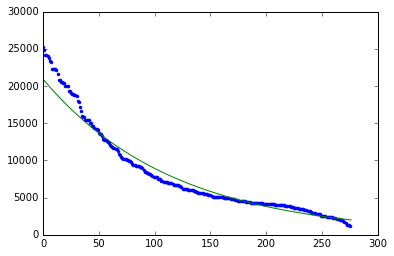

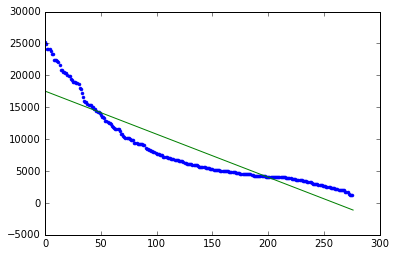

[-0.0085228223158796221, 9.9483660297961087, -67.580209172730306, 17531.971039749827]


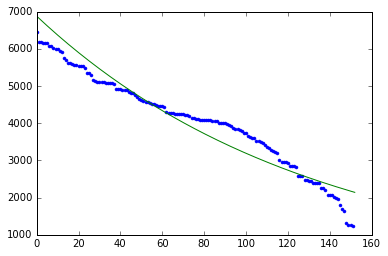

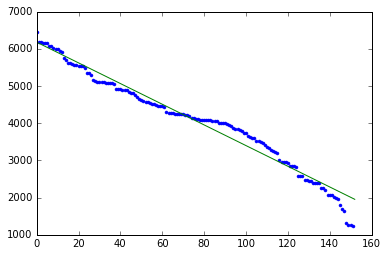

[-0.0076764338106405389, 8.8359478345682092, -27.786964992769857, 6177.4540762926144]


In [68]:
print getFitParameters(data[25])
print getFitParameters(data2split2)